In [1]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import os
import joblib
from pathlib import Path
from tempfile import TemporaryDirectory
from loguru import logger

import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error

from predictability.models import ResidueAgnosticRegressor, PartialLeastSquares, RITARegressor, PottsRegressor
from predictability.utils import update_environment_variables, assign_ssm_folds, ProteinGym
from predictability.sm_utils import get_rita_embeddings, get_potts_emissions, read_sm_credentials
from predictability.constants import DATA_ROOT, PROJECT_ROOT, BINARY_RESIDUE_FEATURES

In [2]:
update_environment_variables("zsh")
read_sm_credentials("old")
DEFAULT_BUCKET = os.environ.get("AWS_DEFAULT_BUCKET")
GLOBAL_DATA_ROOT = os.environ.get("DATA_ROOT")
SEED = 1337
ds = "SRC_HUMAN_Ahler_2019"
n_folds = 10
model_names = ["Residue agnostic regressor", "Partial least squares", "Augmented Potts", "RITA regressor"]
lambda_reg = 0.1
results_dir = PROJECT_ROOT / f"results/{ds}"
results_dir.mkdir(exist_ok=True, parents=True)
rita_training_job_names = joblib.load(PROJECT_ROOT / "misc/rita_training_job_names.joblib")
potts_training_job_names = joblib.load(PROJECT_ROOT / "misc/potts_training_job_names.joblib")
gym = ProteinGym(
    proteingym_location=Path(GLOBAL_DATA_ROOT) / "public/proteingym",
    meta_data_path=Path(GLOBAL_DATA_ROOT) / "public/proteingym/substitutions_raw_DMS/DMS_substitutions.csv"
)
reference = gym.reference_information[gym.reference_information["DMS_id"] == ds]["target_seq"].values[0]

In [3]:
results = {
    "dataset": [],
    "model": [],
    "fold": [],
    "structural_characteristic": [],
    "is_member": [],
    "spearman": [],
    "mae": []
}

data = pd.read_csv(DATA_ROOT / f"{ds}/data.csv").reset_index()
data["residue_number"] = data["mutant"].map(lambda x: int(x[1:-1]))
structural_characteristics = pd.read_csv(DATA_ROOT / ds / "structural_characteristics.csv")
data["embedding_index"] = list(range(len(data)))
data = data.merge(structural_characteristics, on="residue_number")
embedding_indices = data["embedding_index"].values

with TemporaryDirectory() as temp_dir:
    potts_path = get_potts_emissions(
        path=temp_dir,
        dataset=ds,
        training_job_names=potts_training_job_names,
        default_bucket=DEFAULT_BUCKET
    )
    embeddings_path = get_rita_embeddings(
        path=temp_dir,
        dataset=ds,
        training_job_names=rita_training_job_names,
        default_bucket=DEFAULT_BUCKET
    )
    embeddings = np.load(embeddings_path)[embedding_indices]
    models = [
        ResidueAgnosticRegressor(wildtype_sequence=reference),
        PartialLeastSquares(),
        PottsRegressor(potts_path=potts_path, alpha=lambda_reg),
        RITARegressor(alpha=lambda_reg)
    ]

    for feature in BINARY_RESIDUE_FEATURES:
        logger.info(f"Feature: {feature}.")
        for is_member in [0, 1]:
            df = data[data[feature]==is_member].reset_index(drop=True)
            logger.info(f"Is member: {['no', 'yes'][is_member]}.")
            df = assign_ssm_folds(df, n_folds=n_folds, position_col="residue_number", random_seed=SEED)

            for test_fold in range(n_folds):
                logger.info(f"Starting fold {test_fold}.")
                train_indices = np.where(df["ssm_fold"] != test_fold)
                test_indices = np.where(df["ssm_fold"] == test_fold)
                train_data = df[df["ssm_fold"] != test_fold]
                test_data = df[df["ssm_fold"] == test_fold]

                for model, model_name in zip(models, model_names):
                    logger.info(f"Fitting {model_name}.")
                    if model_name == "RITA regressor":
                        model.fit(train_data, target="DMS_score", embeddings=embeddings[train_indices])
                        test_predictions = model.predict(test_data, embeddings=embeddings[test_indices])
                    else:
                        model.fit(train_data, target="DMS_score")
                        test_predictions = model.predict(test_data)
                    mae = mean_absolute_error(test_data["DMS_score"].values, test_predictions)
                    spearman, _ = spearmanr(test_data["DMS_score"].values, test_predictions)

                    results["dataset"].append(ds)
                    results["model"].append(model_name)
                    results["fold"].append(test_fold)
                    results["structural_characteristic"].append(feature)
                    results["is_member"].append(is_member)
                    results["mae"].append(mae)
                    results["spearman"].append(spearman)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/floris/Library/Application Support/sagemaker/config.yaml


2024-03-01 11:18:30.268 | INFO     | predictability.models:__init__:149 - Loading Potts model locally from: /var/folders/d8/bxgj52rj3w934zctbjr8v2hh0000gn/T/tmpja4e9uby
2024-03-01 11:18:37.928 | INFO     | __main__:<module>:40 - Feature: is_buried.
2024-03-01 11:18:37.951 | INFO     | __main__:<module>:43 - Is member: no.
2024-03-01 11:18:38.009 | INFO     | __main__:<module>:47 - Starting fold 0.
2024-03-01 11:18:38.011 | INFO     | __main__:<module>:54 - Fitting Residue agnostic regressor.
2024-03-01 11:18:38.275 | INFO     | __main__:<module>:54 - Fitting Partial least squares.
/Users/floris/work/phd/projects/mutation-predictability/conda_env/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 7
  warnings.warn(f"Y residual is constant at iteration {k}")
2024-03-01 11:18:39.840 | INFO     | __main__:<module>:54 - Fitting Augmented Potts.
2024-03-01 11:18:48.013 | INFO     | __main__:<module>:54 - Fitting RITA regresso

In [4]:
results_df = pd.DataFrame(results)
results_df.to_csv(results_dir / "results.csv")

In [5]:
results_df

,dataset,model,fold,structural_characteristic,is_member,spearman,mae
0,SRC_HUMAN_Ahler_2019,Residue agnostic regressor,0,is_buried,0,0.772352,0.484791
1,SRC_HUMAN_Ahler_2019,Partial least squares,0,is_buried,0,0.772982,0.572579
2,SRC_HUMAN_Ahler_2019,Augmented Potts,0,is_buried,0,0.791573,0.487903
3,SRC_HUMAN_Ahler_2019,RITA regressor,0,is_buried,0,0.555245,0.643863
4,SRC_HUMAN_Ahler_2019,Residue agnostic regressor,1,is_buried,0,0.715861,0.474798
...,...,...,...,...,...,...,...
315,SRC_HUMAN_Ahler_2019,RITA regressor,8,is_secondary,1,0.566571,0.621099
316,SRC_HUMAN_Ahler_2019,Residue agnostic regressor,9,is_secondary,1,0.790191,0.451271
317,SRC_HUMAN_Ahler_2019,Partial least squares,9,is_secondary,1,0.791310,0.558000
318,SRC_HUMAN_Ahler_2019,Augmented Potts,9,is_secondary,1,0.770699,0.487474


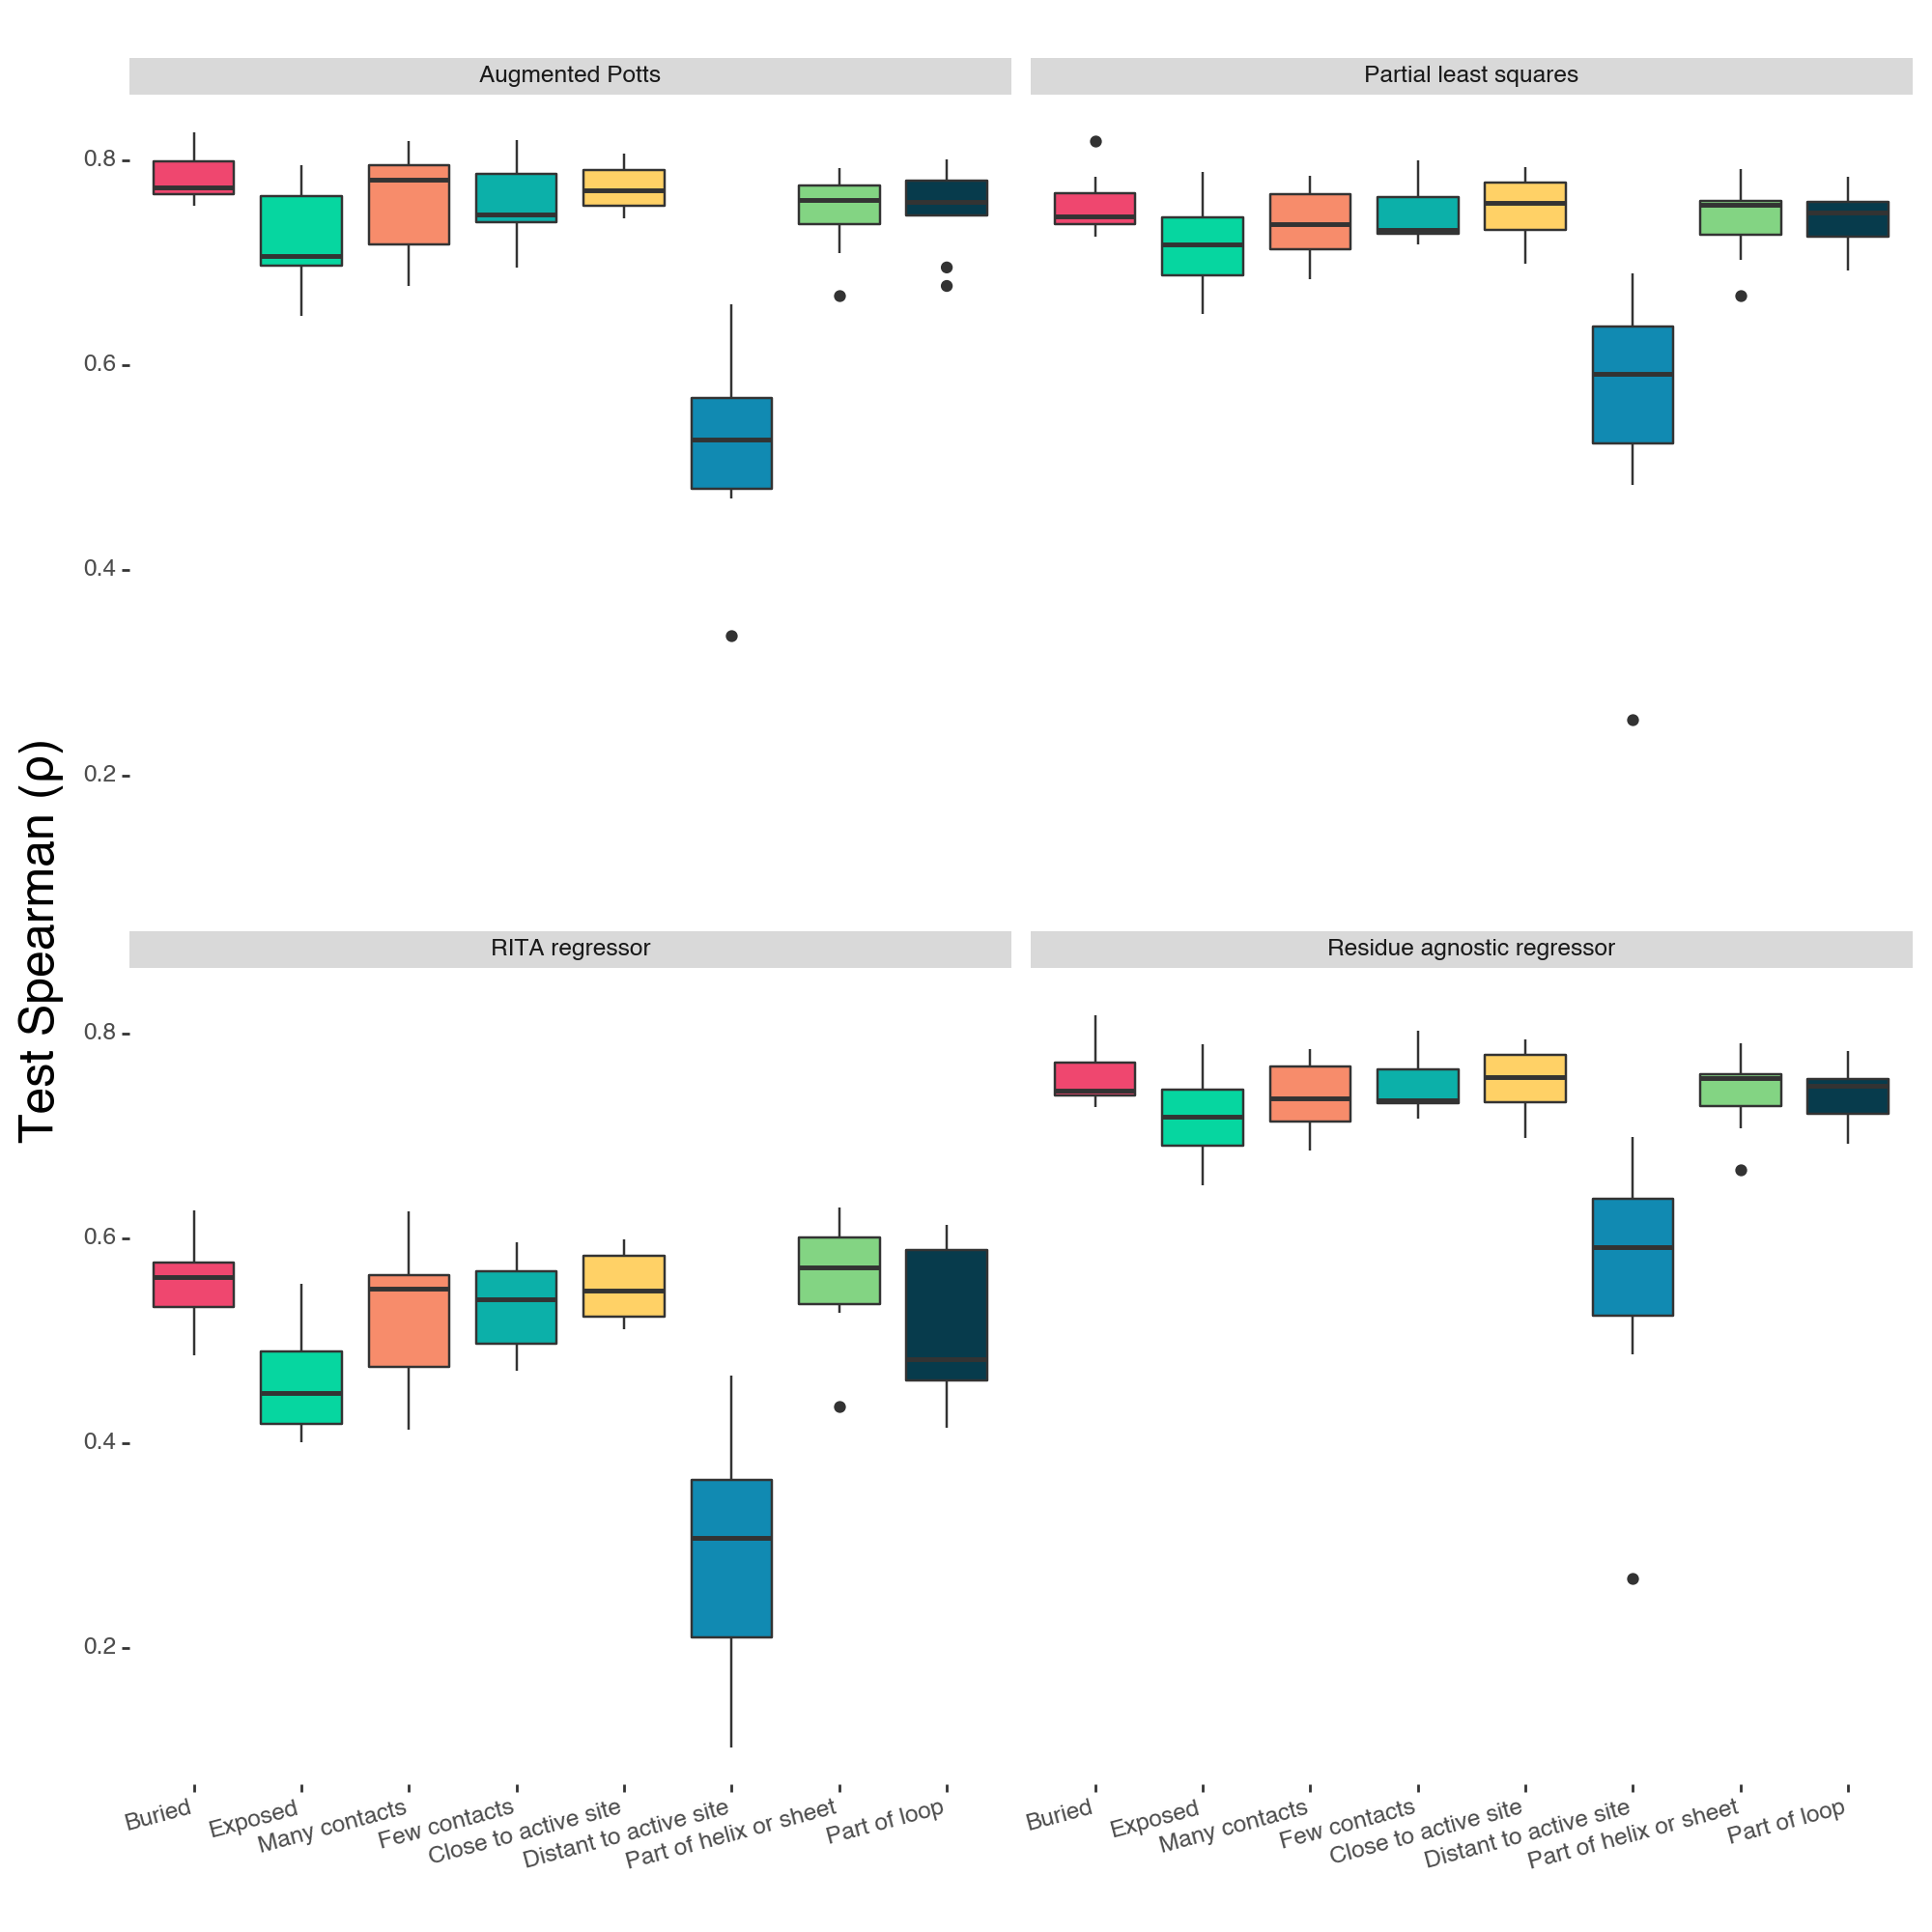

In [6]:
import plotnine as p9
from predictability.plotting import feature_mapping, color_mapping, assign_pretty_feature_names

results_df["is_member"] = results_df["is_member"].astype(bool)
results_df["Feature label"] = results_df["is_member"].apply(lambda x: "Negative" if x==False else "Positive")
results_df["Feature"] = results_df["structural_characteristic"].apply(assign_pretty_feature_names)

results_df["Structural characteristic"] = results_df[['Feature', 'Feature label']].apply(
    lambda x: feature_mapping[tuple(x)], axis=1
)
results_df["Structural characteristic"] = pd.Categorical(results_df["Structural characteristic"],
                                                     categories=["Buried", "Exposed", "Many contacts", "Few contacts",
                                                                 "Close to active site", "Distant to active site",
                                                                 "Part of helix or sheet", "Part of loop"],
                                                     ordered=True)

p = (
    p9.ggplot(
        results_df,
        p9.aes(
            "Structural characteristic",
            "spearman",
            fill="Structural characteristic",
        )
    )
    + p9.geom_boxplot(show_legend=False)
    + p9.facet_wrap("model", nrow=2, ncol=2)
    + p9.theme(figure_size=(10, 10), axis_text_x=p9.element_text(rotation=15, ha="right"))
    + p9.scale_fill_manual(values=color_mapping)
    + p9.theme(
        plot_background=p9.element_rect(fill='white'),
        panel_background=p9.element_rect(fill='white'),
        axis_title_y=p9.element_text(text="Test Spearman (ρ)", size=18),
    )
    + p9.labs(x="")
)
p.draw()
# p.save(save_dir / "supervised_performance_difference.png")
print(p)

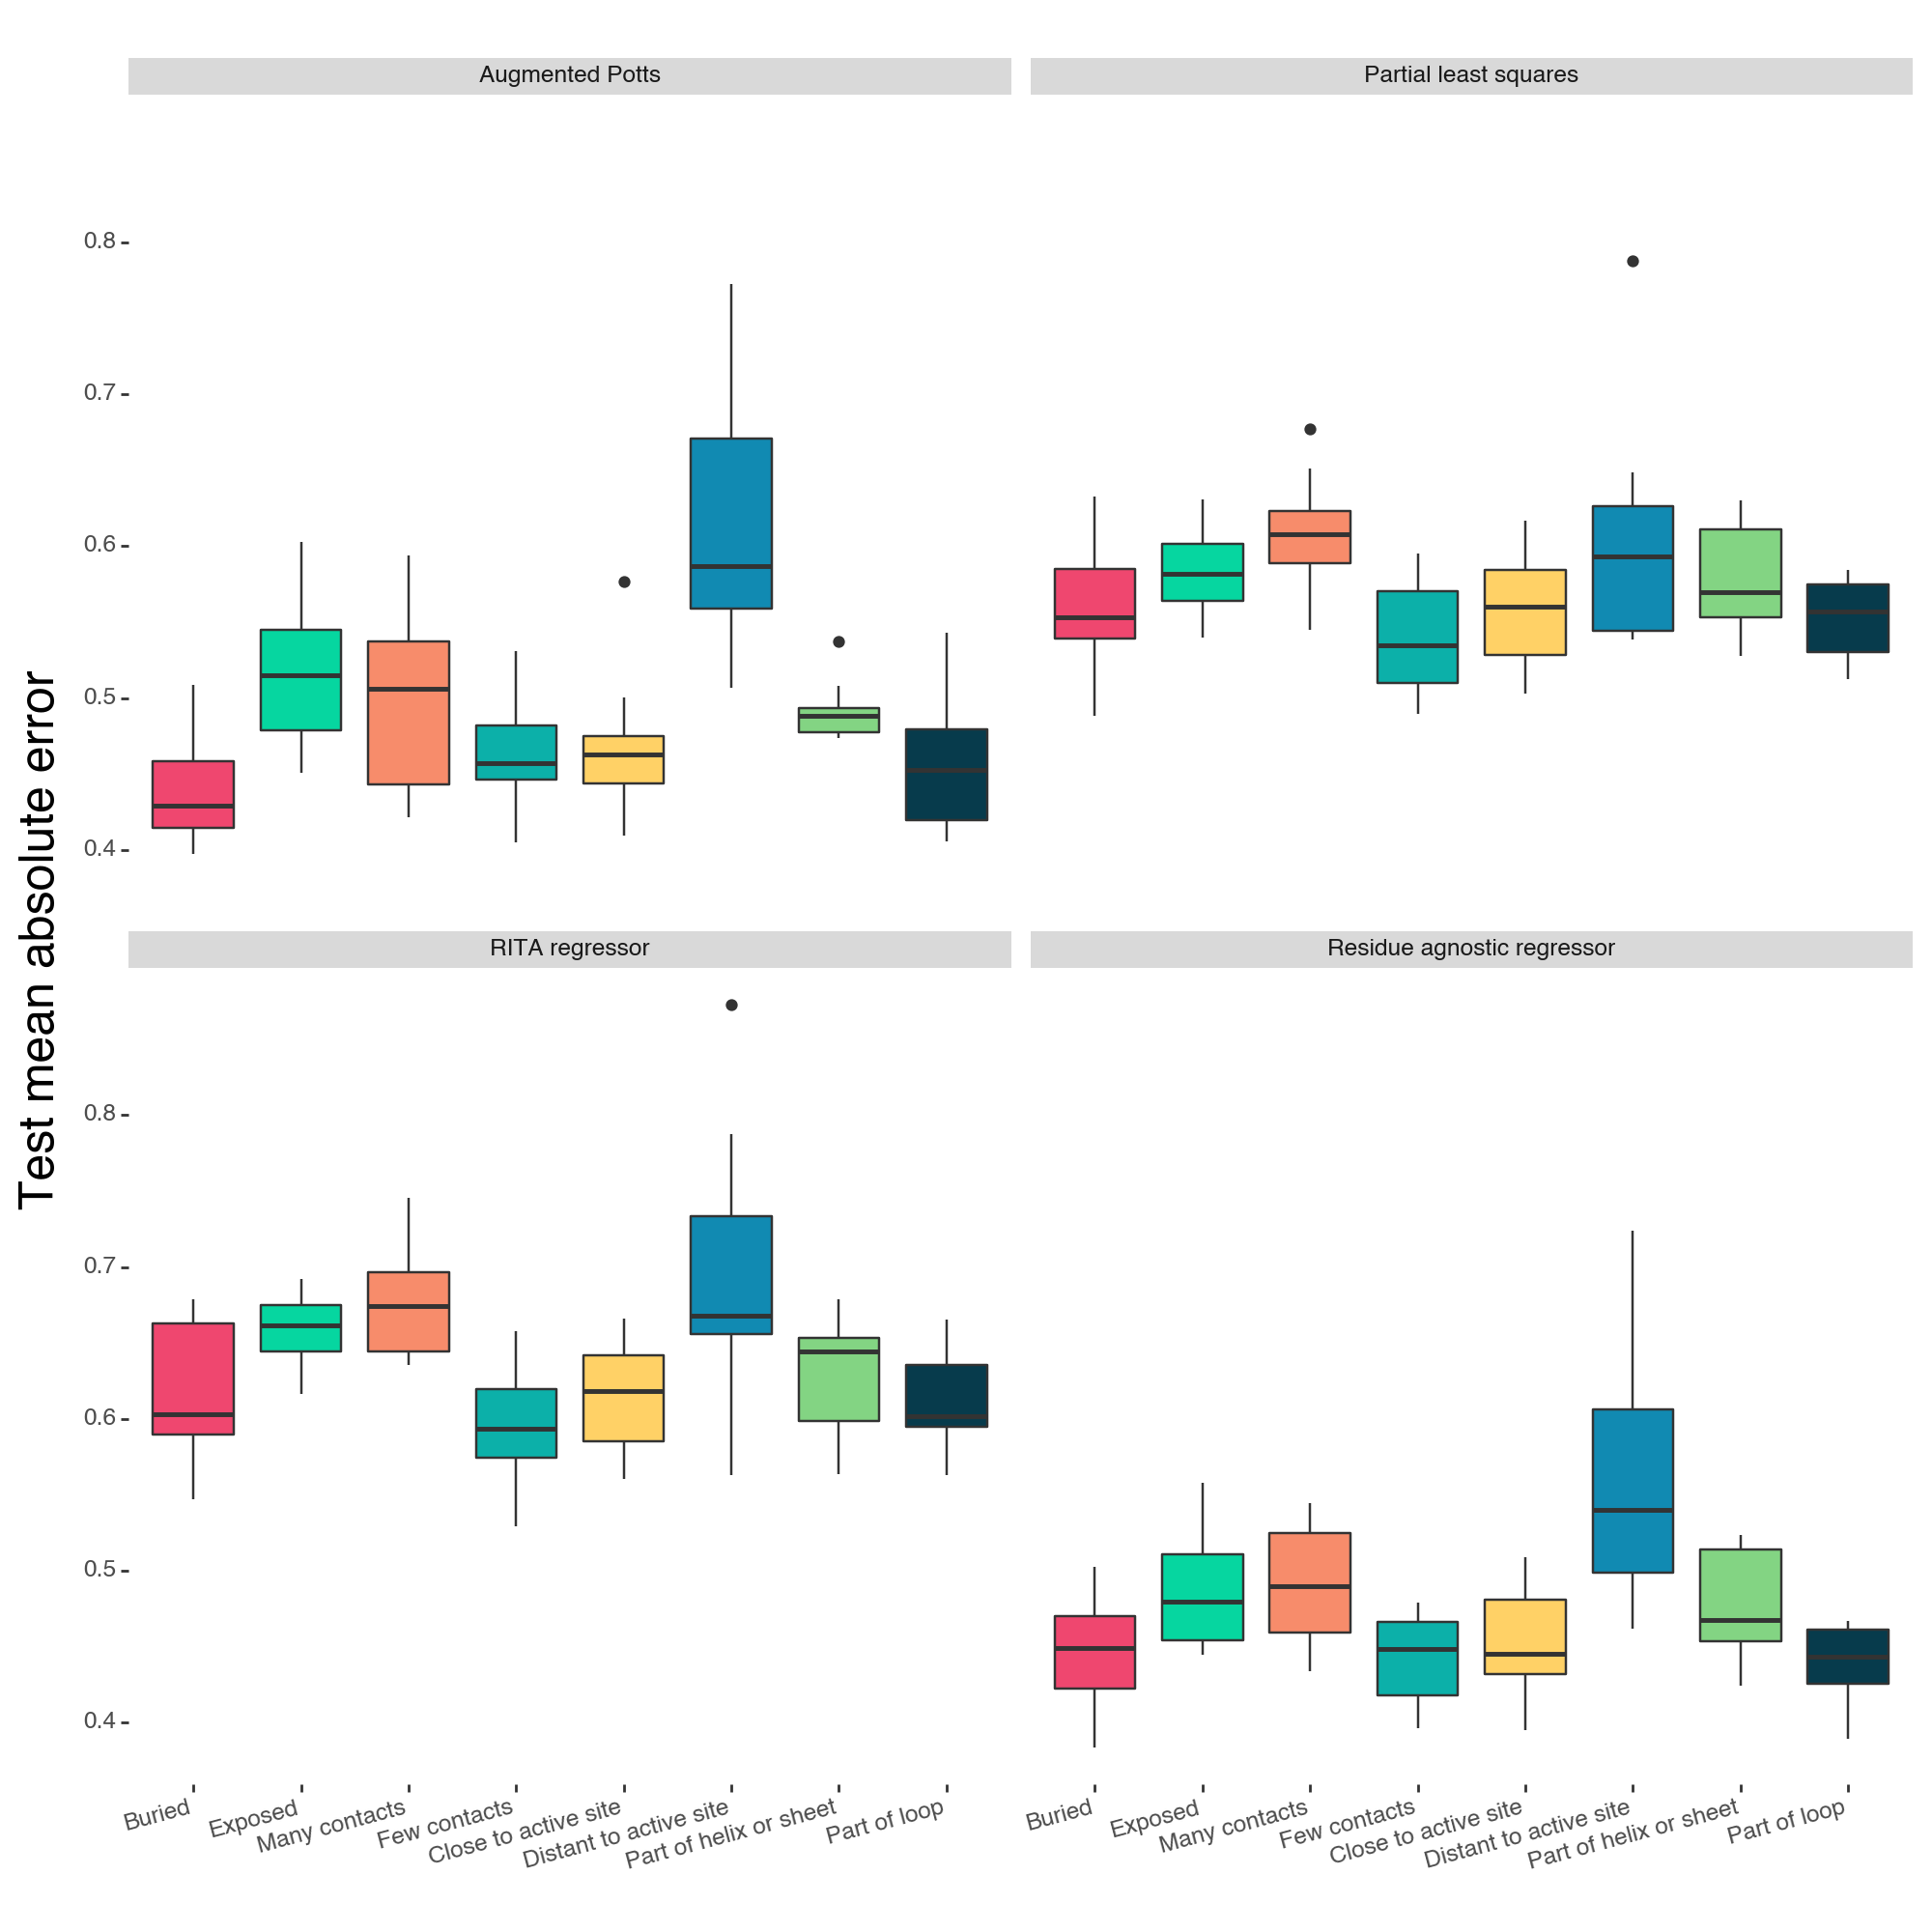

In [7]:
import plotnine as p9
from predictability.plotting import feature_mapping, color_mapping, assign_pretty_feature_names

results_df["is_member"] = results_df["is_member"].astype(bool)
results_df["Feature label"] = results_df["is_member"].apply(lambda x: "Negative" if x==False else "Positive")
results_df["Feature"] = results_df["structural_characteristic"].apply(assign_pretty_feature_names)

results_df["Structural characteristic"] = results_df[['Feature', 'Feature label']].apply(
    lambda x: feature_mapping[tuple(x)], axis=1
)
results_df["Structural characteristic"] = pd.Categorical(results_df["Structural characteristic"],
                                                     categories=["Buried", "Exposed", "Many contacts", "Few contacts",
                                                                 "Close to active site", "Distant to active site",
                                                                 "Part of helix or sheet", "Part of loop"],
                                                     ordered=True)

p = (
    p9.ggplot(
        results_df,
        p9.aes(
            "Structural characteristic",
            "mae",
            fill="Structural characteristic",
        )
    )
    + p9.geom_boxplot(show_legend=False)
    + p9.facet_wrap("model", nrow=2, ncol=2)
    + p9.theme(figure_size=(10, 10), axis_text_x=p9.element_text(rotation=15, ha="right"))
    + p9.scale_fill_manual(values=color_mapping)
    + p9.theme(
        plot_background=p9.element_rect(fill='white'),
        panel_background=p9.element_rect(fill='white'),
        axis_title_y=p9.element_text(text="Test mean absolute error", size=18),
    )
    + p9.labs(x="")
)
p.draw()
# p.save(save_dir / "supervised_performance_difference.png")
print(p)

In [8]:
structural_characteristics = pd.read_csv(DATA_ROOT / ds / "structural_characteristics.csv")
for feat in BINARY_RESIDUE_FEATURES:
    print(feat)
    for is_member in [True, False]:
        print(f"Is member: {is_member}, n_samples:", sum(structural_characteristics[feat] == is_member))

is_buried
Is member: True, n_samples: 222
Is member: False, n_samples: 222
is_connected
Is member: True, n_samples: 197
Is member: False, n_samples: 247
is_close_to_as
Is member: True, n_samples: 222
Is member: False, n_samples: 222
is_secondary
Is member: True, n_samples: 259
Is member: False, n_samples: 185
